<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/itkimage2segimageAndRadiomicsNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook does the last step in the split workflow on Terra**

The NIFTI files generated from Totalsegmentator are provided as input and the DICOM files are downloaded again to generate DICOM SEG Objects

Please cite:
Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

###**Installing Packages**

In [33]:
%%capture
#Installing lz4 for compression/decompression
#xvfb required for previewing Totalsegmentator png images
!apt-get install lz4 dcm2niix wget pigz

In [34]:
%%capture
!pip install pyradiomics nibabel p_tqdm tqdm pydicom

In [35]:
%%capture
dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
dcmqi_download_path = f"dcmqi-1.2.5-linux.tar.gz"
dcmqi_path = f"dcmqi-1.2.5-linux"

!wget -O $dcmqi_download_path $dcmqi_release_url

!tar -xvf $dcmqi_download_path 

!mv $dcmqi_path/bin/* /bin
!rm -r $dcmqi_download_path $dcmqi_path

In [36]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd
!rm CHANGELOG.md LICENSE README.md

###**Importing Packages**

In [37]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
from functools import partial
import glob
import json
import logging
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
from pathlib import Path
import pandas as pd
import psutil
import radiomics
from radiomics import featureextractor
import shutil
import SimpleITK as sitk
import sys
from time import sleep
import time
import tqdm
from tqdm.contrib.concurrent import process_map
from pydicom.filereader import dcmread

logging.getLogger('pyradiomics').setLevel(logging.CRITICAL)

curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Sun May 21 22:41:32 2023

Current directory :/content
Python version    : 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


###**Parameters for Papermill**

In [38]:
csvFilePath=''
inferenceNiftiFilePath=''
converterType='dcm2niix'

###**For local testing**

In [39]:
try:
  os.remove(f'{curr_dir}/batch_1.csv')
  os.remove(f'{curr_dir}/inferenceNiftiFiles.tar.lz4')
except OSError:
  pass

!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
csvFilePath = glob.glob('*.csv')[0]

!wget https://github.com/vkt1414/Cloud-Resources-Workflows/raw/main/sampleManifests/inferenceNiftiFiles.tar.lz4
#Get the file path of the inferenceNiftiFiles
inferenceNiftiFilePath=glob.glob('*.lz4')[0]

--2023-05-21 22:41:32--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>] 136.58K  --.-KB/s    in 0.02s   

2023-05-21 22:41:33 (5.70 MB/s) - ‘batch_1.csv’ saved [139861/139861]

--2023-05-21 22:41:33--  https://github.com/vkt1414/Cloud-Resources-Workflows/raw/main/sampleManifests/inferenceNiftiFiles.tar.lz4
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampl

###Extracting Inference NIFTI files

In [40]:
try:
  shutil.rmtree(f'Inference')
except OSError:
  pass
#!lz4 -d --rm {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf -

!lz4 -d --rm {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf - 
#!rm -r Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/ 

Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/
Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/
Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.nii.lz4
Inference/1.2.840.113654.2.55.142419057730651121165090739113900499978/
Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/
Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215.nii.lz4
Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/
Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033.ni

###Reading CSV File containing s5cmd Urls

In [41]:
start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')  

read in 0.022518157958984375  seconds


###**Downloading Config for DICOM_SEG conversion and Label maps from TotalSegmentator** 

In [42]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole_slicerAsRef.json')
  os.remove(f'{curr_dir}/map_to_binary.py')
except OSError:
  pass
!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
!wget https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
import map_to_binary

--2023-05-21 22:41:34--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76948 (75K) [text/plain]
Saving to: ‘dicomseg_metadata_whole_slicerAsRef.json’

dicomseg_metadata_w 100%[===================>]  75.14K  --.-KB/s    in 0.02s   

2023-05-21 22:41:34 (4.38 MB/s) - ‘dicomseg_metadata_whole_slicerAsRef.json’ saved [76948/76948]

--2023-05-21 22:41:35--  https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.gith

###Functions

In [43]:
try:
  shutil.rmtree(f'itkimage2segimage')
  shutil.rmtree(f'radiomics')
  shutil.rmtree(f'{converterType}')
  shutil.rmtree(f'structuredReports')
except OSError:
  pass
os.mkdir(f'itkimage2segimage')
os.mkdir(f'radiomics')
os.mkdir(f'{converterType}')
os.mkdir(f'structuredReports')

In [44]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [45]:
def convert_dicom_to_nifti(series_id):
  
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files
    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz

In [46]:
#set radiomics verbosity
logger = radiomics.logger
logger.setLevel(logging.WARNING) 

In [47]:
def get_radiomics_features(seg_file, img_file, label=None):
    try:
      standard_features = ['shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength', 'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow', 'shape_Maximum2DDiameterSlice', 'shape_Maximum3DDiameter', 'shape_MeshVolume', 'shape_MinorAxisLength', 'shape_Sphericity', 'shape_SurfaceArea', 'shape_SurfaceVolumeRatio', 'shape_VoxelVolume', 'firstorder_10Percentile', 'firstorder_90Percentile', 'firstorder_Energy', 'firstorder_Entropy', 'firstorder_InterquartileRange', 'firstorder_Kurtosis', 'firstorder_Maximum', 'firstorder_MeanAbsoluteDeviation', 'firstorder_Mean', 'firstorder_Median', 'firstorder_Minimum', 'firstorder_Range', 'firstorder_RobustMeanAbsoluteDeviation', 'firstorder_RootMeanSquared', 'firstorder_Skewness', 'firstorder_TotalEnergy', 'firstorder_Uniformity', 'firstorder_Variance', 'glcm_Autocorrelation', 'glcm_ClusterProminence', 'glcm_ClusterShade', 'glcm_ClusterTendency', 'glcm_Contrast', 'glcm_Correlation', 'glcm_DifferenceAverage', 'glcm_DifferenceEntropy', 'glcm_DifferenceVariance', 'glcm_Id', 'glcm_Idm', 'glcm_Idmn', 'glcm_Idn', 'glcm_Imc1', 'glcm_Imc2', 'glcm_InverseVariance', 'glcm_JointAverage', 'glcm_JointEnergy', 'glcm_JointEntropy', 'glcm_MCC', 'glcm_MaximumProbability', 'glcm_SumAverage', 'glcm_SumEntropy', 'glcm_SumSquares', 'gldm_DependenceEntropy', 'gldm_DependenceNonUniformity', 'gldm_DependenceNonUniformityNormalized', 'gldm_DependenceVariance', 'gldm_GrayLevelNonUniformity', 'gldm_GrayLevelVariance', 'gldm_HighGrayLevelEmphasis', 'gldm_LargeDependenceEmphasis', 'gldm_LargeDependenceHighGrayLevelEmphasis', 'gldm_LargeDependenceLowGrayLevelEmphasis', 'gldm_LowGrayLevelEmphasis', 'gldm_SmallDependenceEmphasis', 'gldm_SmallDependenceHighGrayLevelEmphasis', 'gldm_SmallDependenceLowGrayLevelEmphasis', 'glrlm_GrayLevelNonUniformity', 'glrlm_GrayLevelNonUniformityNormalized', 'glrlm_GrayLevelVariance', 'glrlm_HighGrayLevelRunEmphasis', 'glrlm_LongRunEmphasis', 'glrlm_LongRunHighGrayLevelEmphasis', 'glrlm_LongRunLowGrayLevelEmphasis', 'glrlm_LowGrayLevelRunEmphasis', 'glrlm_RunEntropy', 'glrlm_RunLengthNonUniformity', 'glrlm_RunLengthNonUniformityNormalized', 'glrlm_RunPercentage', 'glrlm_RunVariance', 'glrlm_ShortRunEmphasis', 'glrlm_ShortRunHighGrayLevelEmphasis', 'glrlm_ShortRunLowGrayLevelEmphasis', 'glszm_GrayLevelNonUniformity', 'glszm_GrayLevelNonUniformityNormalized', 'glszm_GrayLevelVariance', 'glszm_HighGrayLevelZoneEmphasis', 'glszm_LargeAreaEmphasis', 'glszm_LargeAreaHighGrayLevelEmphasis', 'glszm_LargeAreaLowGrayLevelEmphasis', 'glszm_LowGrayLevelZoneEmphasis', 'glszm_SizeZoneNonUniformity', 'glszm_SizeZoneNonUniformityNormalized', 'glszm_SmallAreaEmphasis', 'glszm_SmallAreaHighGrayLevelEmphasis', 'glszm_SmallAreaLowGrayLevelEmphasis', 'glszm_ZoneEntropy', 'glszm_ZonePercentage', 'glszm_ZoneVariance', 'ngtdm_Busyness', 'ngtdm_Coarseness', 'ngtdm_Complexity', 'ngtdm_Contrast', 'ngtdm_Strength']
      settings = {}
      settings["resampledPixelSpacing"] = [3,3,3]
      settings["geometryTolerance"] = 1e-3
      settings["featureClass"] = ["shape"]
      radiomics.setVerbosity(logging.CRITICAL)
      extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
      extractor.disableAllFeatures()
      extractor.enableFeatureClassByName("shape")
      extractor.enableFeatureClassByName("firstorder")
      features = extractor.execute(str(img_file), str(seg_file), label=label)
      features = {k.replace("original_", ""): v for k, v in features.items() if k.startswith("original_")}
      features = {k: round(float(v), 4) for k, v in features.items()}
    except Exception as e:
      print(f"WARNING: radiomics raised an exception (settings all features to 0): {e}")
      features = {feat: 0 for feat in standard_features}

    return label, features

In [48]:
# from tqdm import tqdm
# import multiprocessing
# from functools import partial

# def process_mask(seg_file, ct_file, label_id_body_part_df, label):
#     mask_name, mask_stats = get_radiomics_features(seg_file, ct_file, label=label)
#     mask_stats = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in mask_stats.items()}
#     body_part = label_id_body_part_df.loc[label_id_body_part_df['label_id'] == label]['body_part'].values[0]
#     return (body_part, mask_stats)

# def get_radiomics_features_for_all_labels(ct_file: Path, seg_file: Path, file_out: Path):
#     label_id_body_part_data = map_to_binary.class_map['total'].items()
#     # create a DataFrame from the extracted data
#     label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
#     stats = {}
#     labels = [int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0]
#     with multiprocessing.Pool() as pool:
#         func = partial(process_mask, seg_file, ct_file, label_id_body_part_df)
#         results = list(tqdm(pool.imap(func, labels), total=len(labels)))
#     for body_part, mask_stats in results:
#         stats[body_part] = mask_stats
#     with open(file_out, "w") as f:
#         json.dump(stats, f, indent=4)

In [49]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
def process_mask(seg_file, ct_file, label_id_body_part_df, label):
    mask_name, mask_stats = get_radiomics_features(seg_file, ct_file, label=label)
    mask_stats = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in mask_stats.items()}
    body_part = label_id_body_part_df.loc[label_id_body_part_df['label_id'] == label]['body_part'].values[0]
    return (body_part, mask_stats)

def get_radiomics_features_for_all_labels(ct_file: Path, seg_file: Path, file_out: Path):
    label_id_body_part_data = map_to_binary.class_map['total'].items()
    # create a DataFrame from the extracted data
    label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
    stats = {}
    labels = [int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0]
    with ThreadPoolExecutor() as executor:
        func = partial(process_mask, seg_file, ct_file, label_id_body_part_df)
        results = list(tqdm(executor.map(func, labels), total=len(labels)))
    for body_part, mask_stats in results:
        stats[body_part] = mask_stats
    with open(file_out, "w") as f:
        json.dump(stats, f, indent=4)

In [50]:
def remove_directories_without_nii_files(path):
    for dirpath, dirnames, filenames in os.walk(path, topdown=False):
        if dirpath != path and not any(filename.endswith('.nii.lz4') for filename in filenames):
            try:
                os.rmdir(dirpath)
            except OSError as e:
                print(f"Error: Failed to remove directory {dirpath}: {e}")

In [51]:
# !wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/radiomicsFeaturesMaps.csv
# !wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/TotalSegmentator%20v1%20SCT%20mapping%20-%20total.csv
import pandas as pd
nnunet_segments_code_mapping_df=pd.read_csv('https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/TotalSegmentator%20v1%20SCT%20mapping%20-%20total.csv')
nnunet_shape_features_code_mapping_df=pd.read_csv('https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/radiomicsFeaturesMaps.csv')

In [52]:
#removing empty directories
remove_directories_without_nii_files(os.path.join(curr_dir,'Inference/'))

In [53]:
def check_itkimage_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('itkimage2segimage_error_file.txt', 'a') as f:
            f.write(f"Error: itkimage2segimage failed for series {series_id}\n")
        return True
    return False

In [54]:
def check_radiomics_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('radiomics_error_file.txt', 'a') as f:
            f.write(f"Error: Radiomics Feature extraction failed for series {series_id}\n")
        return True
    return False

In [55]:
def order_dicom_files_image_position(dcm_directory):
  """
  Orders the dicom files according to image position and orientation. 

  Arguments:
    dcm_directory : input directory of dcm files to put in order 

  Outputs:
    files_sorted   : dcm files in sorted order 
    sop_all_sorted : the SOPInstanceUIDs in sorted order 
    pos_all_sorted : the image position in sorted order 

  """
  files = [os.path.join(dcm_directory,f) for f in os.listdir(dcm_directory)]

  num_files = len(files)

  pos_all = []  
  sop_all = [] 

  for n in range(0,num_files):
    # read dcm file 
    filename = files[n]
    ds = dcmread(filename)

    # get ImageOrientation (0020, 0037)
    # ImageOrientation = ds['0x0020','0x0037'].value
    ImageOrientation = ds.ImageOrientationPatient

    # get ImagePositionPatient (0020, 0032) 
    # ImagePositionPatient = ds['0x0020','0x0032'].value
    ImagePositionPatient = ds.ImagePositionPatient

    # calculate z value
    x_vector = ImageOrientation[0:3]
    y_vector = ImageOrientation[3:]
    z_vector = np.cross(x_vector,y_vector)

    # multiple z_vector by ImagePositionPatient
    pos = np.dot(z_vector,ImagePositionPatient)
    pos_all.append(pos)

    # get the SOPInstanceUID 
    # sop = ds['0x0008', '0x0018'].value
    sop = ds.SOPInstanceUID
    sop_all.append(sop)


  #----- order the SOPInstanceUID/files by z value ----# 

  sorted_ind = np.argsort(pos_all)
  pos_all_sorted = np.array(pos_all)[sorted_ind.astype(int)]
  sop_all_sorted = np.array(sop_all)[sorted_ind.astype(int)]
  files_sorted = np.array(files)[sorted_ind.astype(int)]

  return files_sorted, sop_all_sorted, pos_all_sorted 

In [56]:
# def create_structured_report_metajson_for_shape_features(SeriesInstanceUID, 
#                                                          SOPInstanceUID_seg,
#                                                          seg_file, 
#                                                          dcm_directory, 
#                                                          segments_code_mapping_df,
#                                                          shape_features_code_mapping_df,
#                                                          radiomics_features, 
#                                                          ):
  
#   """Function that creates the metajson necessary for the creation of a
#   structured report from a pandas dataframe of label names and features for 
#   each. 

#   Inputs: 
#     SeriesInstanceUID               : SeriesInstanceUID of the corresponding CT 
#                                       file 
#     SOPInstanceUID_seg              : SOPInstanceUID of the corresponding SEG file 
#     seg_file                        : filename of SEG DCM file 
#     dcm_directory                   : ct directory that will be sorted in 
#                                       terms of axial ordering according to the 
#                                       ImagePositionPatient and ImageOrientation 
#                                       fields
#     segments_code_mapping_df        : dataframe that holds the names of the 
#                                       segments and the associated code values etc.
#     shape_features_code_mapping_df  : dataframe that holds the names of the 
#                                       features and the associated code values etc. 
#     df_features                     : a pandas dataframe holding the segments and a 
#                                       set of 3D shape features for each 

#   Outputs:
#     Returns the metajson for the structured report that will then be used by
#     dcmqi tid1500writer to create a structured report 
#   """ 
#   # --- Get the version number for the pyradiomics package --- #

#   pyradiomics_version_number = str(radiomics.__version__)
  
#   # --- Sort the dcm files first according to --- # 
#   # --- ImagePositionPatient and ImageOrientation --- #

#   files_sorted, sop_all_sorted, pos_all_sorted = order_dicom_files_image_position(dcm_directory)
#   files_sorted = [os.path.basename(f) for f in files_sorted]

#   # --- Create the header for the json --- # 
  
#   inputMetadata = {}
#   inputMetadata["@schema"]= "https://raw.githubusercontent.com/qiicr/dcmqi/master/doc/schemas/sr-tid1500-schema.json#"
#   inputMetadata["SeriesDescription"] = "Measurements"
#   inputMetadata["SeriesNumber"] = "1001"
#   inputMetadata["InstanceNumber"] = "1"

#   inputMetadata["compositeContext"] = [seg_file] # not full path

#   inputMetadata["imageLibrary"] = files_sorted # not full path 
#   inputMetadata["observerContext"] = {
#                       "ObserverType": "DEVICE",
#                       "DeviceObserverName": "pyradiomics",
#                       "DeviceObserverModelName": pyradiomics_version_number
#                     }

#   inputMetadata["VerificationFlag"]  = "UNVERIFIED"
#   inputMetadata["CompletionFlag"] =  "COMPLETE"
#   inputMetadata["activitySession"] = "1"
#   inputMetadata["timePoint"] = "1"

#   # ------------------------------------------------------------------------- # 
#   # --- Create the measurement_dict for each segment - holds all features --- # 

#   measurement = [] 

#   # --- Now create the dict for all features and all segments --- #

#   # --- Loop over the number of segments --- #

#   # number of rows in the df_features 
#   num_segments = radiomics_features.shape[0]
#   print(num_segments)

#   # Array of dictionaries - one dictionary for each segment 
#   measurement_across_segments_combined = [] 

#   for segment_id in range(0,num_segments):

#     ReferencedSegment = int(radiomics_features['label_id'].values[segment_id]) # referencedsegment must be an integer according to the schema.
#     FindingSite = radiomics_features['body_part'].values[segment_id]

#     # print('segment_id: ' + str(segment_id))
#     # print('ReferencedSegment: ' + str(ReferencedSegment))
#     # print('FindingSite: ' + str(FindingSite))

#     # --- Create the dict for the Measurements group --- # 
#     TrackingIdentifier = "Measurements group " + str(ReferencedSegment)

#     segment_row = segments_code_mapping_df[segments_code_mapping_df["Structure"] == FindingSite]


#     # print(segment_row)
        
#     my_dict = {
#       "TrackingIdentifier": str(TrackingIdentifier),
#       "ReferencedSegment": str(ReferencedSegment),
#       "SourceSeriesForImageSegmentation": str(SeriesInstanceUID),
#       "segmentationSOPInstanceUID": str(SOPInstanceUID_seg),
#       "Finding": {
#         "CodeValue": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodeValue"].iloc[0]),
#         "CodingSchemeDesignator": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator"].iloc[0]),
#         "CodeMeaning": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodeMeaning"].iloc[0]),
#       }, 
#       "FindingSite": {
#         "CodeValue": str(segment_row["SegmentedPropertyTypeCodeSequence.CodeValue"].iloc[0]),
#         "CodingSchemeDesignator": str(segment_row["SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator"].iloc[0]),
#         "CodeMeaning": str(segment_row["SegmentedPropertyTypeCodeSequence.CodeMeaning"].iloc[0]),
#       },
#       "Laterality": {
#           "CodeValue": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeValue"].iloc[0]),
#           "CodingSchemeDesignator": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator"].iloc[0]),
#           "CodeMeaning": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeMeaning"].iloc[0])
#       } 
      
#     }
    
#     measurement = []  
#     # number of features - number of columns in df_features - 2 (label_name and ReferencedSegment)
#     num_values = len(radiomics_features.columns)-2 

#     #feature_list = radiomics_features.columns[2:] # remove first two 
#     feature_list = nnunet_shape_features_code_mapping_df.feature.to_list()

#     # For each measurement per region segment
#     for n in range(0,len(feature_list)): 
#       measurement_dict = {}
#       row = radiomics_features.loc[radiomics_features['body_part'] == FindingSite]
#       feature_row = shape_features_code_mapping_df.loc[shape_features_code_mapping_df["feature"] == feature_list[n]]
#       value = str(np.round(row[feature_list[n]].values[0],3))
#       measurement_dict["value"] = value
#       measurement_dict["quantity"] = {}
#       measurement_dict["quantity"]["CodeValue"] = str(feature_row["quantity_CodeValue"].values[0])
#       measurement_dict["quantity"]["CodingSchemeDesignator"] = str(feature_row["quantity_CodingSchemeDesignator"].values[0])
#       measurement_dict["quantity"]["CodeMeaning"] = str(feature_row["quantity_CodeMeaning"].values[0])
#       measurement_dict["units"] = {}
#       measurement_dict["units"]["CodeValue"] = str(feature_row["units_CodeValue"].values[0])
#       measurement_dict["units"]["CodingSchemeDesignator"] = str(feature_row["units_CodingSchemeDesignator"].values[0])
#       measurement_dict["units"]["CodeMeaning"] = str(feature_row["units_CodeMeaning"].values[0])
#       measurement_dict["measurementAlgorithmIdentification"] = {}
#       measurement_dict["measurementAlgorithmIdentification"]["AlgorithmName"] = "pyradiomics"
#       measurement_dict["measurementAlgorithmIdentification"]["AlgorithmVersion"] = str(pyradiomics_version_number)
#       measurement.append(measurement_dict) 

#     measurement_combined_dict = {}
#     measurement_combined_dict['measurementItems'] = measurement # measurement is an array of dictionaries 

#     output_dict_one_segment = {**my_dict, **measurement_combined_dict}

#     # append to array for all segments 

#     measurement_across_segments_combined.append(output_dict_one_segment)

#   # --- Add the measurement data --- # 

#   inputMetadata["Measurements"] = {}
#   inputMetadata["Measurements"] = measurement_across_segments_combined

#   return inputMetadata

In [57]:
def create_structured_report_metajson_for_shape_features(SeriesInstanceUID, 
                                                         SOPInstanceUID_seg,
                                                         seg_file, 
                                                         dcm_directory, 
                                                         segments_code_mapping_df,
                                                         shape_features_code_mapping_df,
                                                         radiomics_features, 
                                                         ):
  
  """Function that creates the metajson necessary for the creation of a
  structured report from a pandas dataframe of label names and features for 
  each. 

  Inputs: 
    SeriesInstanceUID               : SeriesInstanceUID of the corresponding CT 
                                      file 
    SOPInstanceUID_seg              : SOPInstanceUID of the corresponding SEG file 
    seg_file                        : filename of SEG DCM file 
    dcm_directory                   : ct directory that will be sorted in 
                                      terms of axial ordering according to the 
                                      ImagePositionPatient and ImageOrientation 
                                      fields
    segments_code_mapping_df        : dataframe that holds the names of the 
                                      segments and the associated code values etc.
    shape_features_code_mapping_df  : dataframe that holds the names of the 
                                      features and the associated code values etc. 
    df_features                     : a pandas dataframe holding the segments and a 
                                      set of 3D shape features for each 

  Outputs:
    Returns the metajson for the structured report that will then be used by
    dcmqi tid1500writer to create a structured report 
  """ 
  # --- Get the version number for the pyradiomics package --- #

  pyradiomics_version_number = str(radiomics.__version__)
  
  # --- Sort the dcm files first according to --- # 
  # --- ImagePositionPatient and ImageOrientation --- #

  files_sorted, sop_all_sorted, pos_all_sorted = order_dicom_files_image_position(dcm_directory)
  files_sorted = [os.path.basename(f) for f in files_sorted]

  # --- Create the header for the json --- # 
  
  inputMetadata = {}
  inputMetadata["@schema"]= "https://raw.githubusercontent.com/qiicr/dcmqi/master/doc/schemas/sr-tid1500-schema.json#"
  inputMetadata["SeriesDescription"] = "Measurements"
  inputMetadata["SeriesNumber"] = "1001"
  inputMetadata["InstanceNumber"] = "1"

  inputMetadata["compositeContext"] = [seg_file] # not full path

  inputMetadata["imageLibrary"] = files_sorted # not full path 
  inputMetadata["observerContext"] = {
                      "ObserverType": "DEVICE",
                      "DeviceObserverName": "pyradiomics",
                      "DeviceObserverModelName": pyradiomics_version_number
                    }

  inputMetadata["VerificationFlag"]  = "UNVERIFIED"
  inputMetadata["CompletionFlag"] =  "COMPLETE"
  inputMetadata["activitySession"] = "1"
  inputMetadata["timePoint"] = "1"

  # ------------------------------------------------------------------------- # 
  # --- Create the measurement_dict for each segment - holds all features --- # 

  measurement = [] 

  # --- Now create the dict for all features and all segments --- #

  # --- Loop over the number of segments --- #

  # number of rows in the df_features 
  num_segments = radiomics_features.shape[0]
  print(num_segments)

  # Array of dictionaries - one dictionary for each segment 
  measurement_across_segments_combined = [] 

  for segment_id in range(0,num_segments):

    ReferencedSegment = int(radiomics_features['label_id'].values[segment_id]) # referencedsegment must be an integer according to the schema.
    FindingSite = radiomics_features['body_part'].values[segment_id]

    # print('segment_id: ' + str(segment_id))
    # print('ReferencedSegment: ' + str(ReferencedSegment))
    # print('FindingSite: ' + str(FindingSite))

    # --- Create the dict for the Measurements group --- # 
    TrackingIdentifier = "Measurements group " + str(ReferencedSegment)

    segment_row = segments_code_mapping_df[segments_code_mapping_df["Structure"] == FindingSite]


    # print(segment_row)
        
    my_dict = {
      "TrackingIdentifier": str(TrackingIdentifier),
      "ReferencedSegment": str(ReferencedSegment),
      "SourceSeriesForImageSegmentation": str(SeriesInstanceUID),
      "segmentationSOPInstanceUID": str(SOPInstanceUID_seg),
      "Finding": {
        "CodeValue": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodeValue"].iloc[0]),
        "CodingSchemeDesignator": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator"].iloc[0]),
        "CodeMeaning": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodeMeaning"].iloc[0]),
      }, 
      "FindingSite": {
        "CodeValue": str(segment_row["SegmentedPropertyTypeCodeSequence.CodeValue"].iloc[0]),
        "CodingSchemeDesignator": str(segment_row["SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator"].iloc[0]),
        "CodeMeaning": str(segment_row["SegmentedPropertyTypeCodeSequence.CodeMeaning"].iloc[0]),
      },
      "Laterality": {
          "CodeValue": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeValue"].iloc[0]),
          "CodingSchemeDesignator": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator"].iloc[0]),
          "CodeMeaning": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeMeaning"].iloc[0])
      } 
      
    }
    
    measurement = []  
    # number of features - number of columns in df_features - 2 (label_name and ReferencedSegment)
    num_values = len(radiomics_features.columns)-2 

    #feature_list = radiomics_features.columns[2:] # remove first two 
    feature_list = nnunet_shape_features_code_mapping_df.feature.to_list()

    # For each measurement per region segment
    for n in range(0,len(feature_list)): 
      measurement_dict = {}
      row = radiomics_features.loc[radiomics_features['body_part'] == FindingSite]
      feature_row = shape_features_code_mapping_df.loc[shape_features_code_mapping_df["feature"] == feature_list[n]]
      value = str(np.round(row[feature_list[n]].values[0],3))
      measurement_dict["value"] = value
      measurement_dict["quantity"] = {}
      measurement_dict["quantity"]["CodeValue"] = str(feature_row["quantity_CodeValue"].values[0])
      measurement_dict["quantity"]["CodingSchemeDesignator"] = str(feature_row["quantity_CodingSchemeDesignator"].values[0])
      measurement_dict["quantity"]["CodeMeaning"] = str(feature_row["quantity_CodeMeaning"].values[0])
      measurement_dict["units"] = {}
      measurement_dict["units"]["CodeValue"] = str(feature_row["units_CodeValue"].values[0])
      measurement_dict["units"]["CodingSchemeDesignator"] = str(feature_row["units_CodingSchemeDesignator"].values[0])
      measurement_dict["units"]["CodeMeaning"] = str(feature_row["units_CodeMeaning"].values[0])
      measurement_dict["measurementAlgorithmIdentification"] = {}
      measurement_dict["measurementAlgorithmIdentification"]["AlgorithmName"] = "pyradiomics"
      measurement_dict["measurementAlgorithmIdentification"]["AlgorithmVersion"] = str(pyradiomics_version_number)
      measurement.append(measurement_dict) 

    measurement_combined_dict = {}
    measurement_combined_dict['measurementItems'] = measurement # measurement is an array of dictionaries 

    output_dict_one_segment = {**my_dict, **measurement_combined_dict}

    # append to array for all segments 

    measurement_across_segments_combined.append(output_dict_one_segment)

  # --- Add the measurement data --- # 

  inputMetadata["Measurements"] = {}
  inputMetadata["Measurements"] = measurement_across_segments_combined

  sr_json_path=f'{curr_dir}/structuredReports/{series_id}/{series_id}_sr.json'
  sr_path=f'{curr_dir}/structuredReports/{series_id}/{series_id}_sr.dcm'
  pred_dicomseg_path=f'{curr_dir}/itkimage2segimage/{series_id}/'

  with open(sr_json_path, 'w') as f:
    json.dump(inputMetadata, f, indent=2)
    print ('wrote out json for shape features')

  inputImageLibraryDirectory = dcm_directory
  # outputDICOM = sr_json_path
  outputDICOM = sr_path
  # the name of the folder where the seg files are located 
  inputCompositeContextDirectory = os.path.basename(pred_dicomseg_path) # might need to check this
  inputMetadata_json = sr_json_path 

  print ('inputImageLibraryDirectory: ' + str(inputImageLibraryDirectory))
  print ('outputDICOM: ' + str(outputDICOM))
  print ('inputCompositeContextDirectory: ' + str(inputCompositeContextDirectory))
  print ('inputMetadata_json: ' + str(inputMetadata_json)) 
  !tid1500writer --inputImageLibraryDirectory $inputImageLibraryDirectory \
                --outputDICOM $outputDICOM  \
                --inputCompositeContextDirectory $inputCompositeContextDirectory \
                --inputMetadata $inputMetadata_json
  print ('wrote out SR for shape features')

  

In [58]:
# def save_structured_report_for_shape_features(
#                                               SeriesInstanceUID, 
#                                               SOPInstanceUID_seg, 
#                                               pred_dicomseg_path, 
#                                               dcm_directory, 
#                                               segments_code_mapping_df,
#                                               shape_features_code_mapping_df,
#                                               sr_json_path,
#                                               sr_path,
#                                               df_features
#                                               ):
  
#   """ This function creates the SR necessary for the nnUNet shape features 

#   Inputs: 
#   SeriesInstanceUID               : SeriesInstanceUID of the corresponding CT 
#                                     file 
#   SOPInstanceUID_seg              : SOPInstanceUID of the corresponding SEG file 
#   pred_dicomseg_path              : filename of DICOM SEG file 
#   dicomseg_json_path              : json file for DICOM SEG file 
#   dcm_directory                   : list of ct files that will be sorted in 
#                                     terms of axial ordering according to the 
#                                     ImagePositionPatient and ImageOrientation 
#                                     fields
#   pred_nifti_path                 : predictions in nifti format 
#   nnunet_base_path                : path to hold the split nifti files 
#   ct_nifti_path                   : filename for CT nifti file
#   segments_code_mapping_df        : dataframe that holds the names of the 
#                                     segments and the associated code values etc.
#   shape_features_code_mapping_df  : dataframe that holds the names of the 
#                                     features and the associated code values etc. 
#   sr_json_path                    : the path that the metajson for the SR for 
#                                     the 3D shape features will be saved 
#   sr_path                         : the path that the SR for the 3D shape 
#                                     features will be saved 

#   Outputs:
#     Returns the metajson for the structured report that will then be used by
#     dcmqi tid1500writer to create a structured report 

#   """

#   # # --- get label values and names from metajson file --- #
#   # label_values, label_names = get_label_and_names_from_metadata_json(dicomseg_json_path)

#   # # --- split the multilabel nifti into individual files --- #
#   # split_pred_nii_path = os.path.join(nnunet_base_path, "split_nii")
#   # if not os.path.isdir(split_pred_nii_path): 
#   #   os.mkdir(split_pred_nii_path)
#   # split_nii(pred_nifti_path, split_pred_nii_path, label_names)

#   # # --- compute features and save csv for each region --- #
#   # if not os.path.isdir(features_csv_path_nnunet):
#   #   os.mkdir(features_csv_path_nnunet) 
#   # df_features = compute_pyradiomics_3D_features(ct_nifti_path, 
#   #                                               label_values, 
#   #                                               label_names,
#   #                                               split_pred_nii_path, 
#   #                                               nnunet_shape_features_code_mapping_df)
#   # print ('created df_features')
  
#   # --- upload csv file to bucket --- #
#   # !$s5cmd_path --endpoint-url https://storage.googleapis.com cp $pred_features_csv_path $gs_uri_features_csv_file

#   # # remove nii files after saving out pyradiomics results
#   # !rm $split_pred_nii_path/*
#   # # remove csv 
#   # # !rm $pred_features_csv_path

#   # --- Create the final metadata for the SR --- #
#   inputMetadata = create_structured_report_metajson_for_shape_features(SeriesInstanceUID, 
#                                                                        SOPInstanceUID_seg,
#                                                                        pred_dicomseg_path, 
#                                                                        dcm_directory, 
#                                                                        segments_code_mapping_df, 
#                                                                        shape_features_code_mapping_df,
#                                                                        df_features)

#   print ('created SR json for shape features')

#   # --- Write out json --- #

#   with open(sr_json_path, 'w') as f:
#     json.dump(inputMetadata, f, indent=2)
#   print ('wrote out json for shape features')

#   # --- Save the SR for nnUNet shape features --- # 
#   # inputImageLibraryDirectory = os.path.join("/content", "raw")
#   # outputDICOM = os.path.join("/content","features_sr.dcm")
#   # inputCompositeContextDirectory = os.path.join("/content","seg")
#   inputImageLibraryDirectory = dcm_directory
#   # outputDICOM = sr_json_path
#   outputDICOM = sr_path
#   # the name of the folder where the seg files are located 
#   inputCompositeContextDirectory = os.path.basename(pred_dicomseg_path) # might need to check this
#   inputMetadata_json = sr_json_path 

#   print ('inputImageLibraryDirectory: ' + str(inputImageLibraryDirectory))
#   print ('outputDICOM: ' + str(outputDICOM))
#   print ('inputCompositeContextDirectory: ' + str(inputCompositeContextDirectory))
#   print ('inputMetadata_json: ' + str(inputMetadata_json)) 
#   !tid1500writer --inputImageLibraryDirectory $inputImageLibraryDirectory \
#                 --outputDICOM $outputDICOM  \
#                 --inputCompositeContextDirectory $inputCompositeContextDirectory \
#                 --inputMetadata $inputMetadata_json
#   print ('wrote out SR for shape features')

#   return 

In [59]:
def itkimage2segimageAndRadiomics(series_id):
      try:
        shutil.rmtree(f'itkimage2segimage/{series_id}')
        shutil.rmtree(f'radiomics/{series_id}')
        shutil.rmtree(f'{curr_dir}/structuredReports/{series_id}')
      except OSError:
        pass
        os.mkdir(f'itkimage2segimage/{series_id}')
        os.mkdir(f'radiomics/{series_id}')
        os.mkdir(f'{curr_dir}/structuredReports/{series_id}')

      print("Processing series: "+series_id)  

      """
      Downloading DICOM files only for the Series with Totalsegmentator NIFTI files

      """
      download_dicom_data(series_id) 
      convert_dicom_to_nifti(series_id)

      #Get Inference NIFTI file path
      inference_nifti_filename_path = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.lz4')
      inference_nifti_filename = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii')
      
      try:
        os.remove(inference_nifti_filename)
      except OSError:
        pass
      !lz4 -d --rm {inference_nifti_filename_path}

      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory {curr_dir}/idc_data/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/dicomseg_metadata_whole_slicerAsRef.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("Done in %g seconds."%itkimage2segimage_time)
      
      check_itkimage_errors(series_id)


      ct_series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      ct_nifti_files = os.listdir(ct_series_id_folder_path)
      # Get the first (and only) file in the list
      ct_nifti_filename = ct_nifti_files[0]
      # Get the full path of the file
      ct_nifti_filename_path = os.path.join(ct_series_id_folder_path, ct_nifti_filename)
      
      radiomics_output_filename= os.path.join(curr_dir, 'radiomics', series_id, f'{series_id}_radiomics.json')
      
      start_time = time.time()   
      get_radiomics_features_for_all_labels(ct_nifti_filename_path, inference_nifti_filename, radiomics_output_filename)
      radiomics_time = time.time() - start_time
      print("Radiomics Features Calculation Done in %g seconds."%radiomics_time)
      
      check_radiomics_errors(series_id)


      radiomics_features = pd.read_json(os.path.join(curr_dir, 'radiomics', series_id, f'{series_id}_radiomics.json'), orient='index')
      radiomics_features = radiomics_features.rename(columns=lambda x: x.split('_')[-1])
      radiomics_features = radiomics_features.reset_index().rename(columns={'index': 'body_part'})
      label_id_body_part_data = map_to_binary.class_map['total'].items()
      label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
      radiomics_features = pd.merge(radiomics_features, label_id_body_part_df, on='body_part')
      cols = radiomics_features.columns.tolist()
      cols.insert(1, cols.pop(cols.index('label_id')))
      radiomics_features = radiomics_features[cols]

      seg_dcm=dcmread(f'{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm')
      SOPInstanceUID_seg=seg_dcm.file_meta['0x0002', '0x0003'].value

      seg_file=f'{series_id}.dcm'
      dcm_directory=f'{curr_dir}/idc_data/' 
      segments_code_mapping_df=nnunet_segments_code_mapping_df
      shape_features_code_mapping_df=nnunet_shape_features_code_mapping_df

      create_structured_report_metajson_for_shape_features( SeriesInstanceUID, 
                                                            SOPInstanceUID_seg,
                                                            seg_file, 
                                                            dcm_directory, 
                                                            segments_code_mapping_df,
                                                            shape_features_code_mapping_df,
                                                            radiomics_features, 
                                                            )

      start_time = time.time()     
      !lz4 --rm {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
      !lz4 --rm {curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json  {curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json.lz4
      archiving_time = time.time() - start_time
      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      log['itkimage2segimage_time']=itkimage2segimage_time
      log['archiving_time'] = archiving_time
      log['radiomics_time']= radiomics_time

      !rm -r {curr_dir}/Inference/{series_id}
      #!rm -r {curr_dir}/idc_data
      !rm -r {curr_dir}/{converterType}/{series_id}

      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [60]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.2.840.113654.2.55.22770087029972268579113866309746562015
Copying files from IDC buckets..
Done in 1.3178 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2 (512x512x128x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2.nii"
Conversion required 7.209426 seconds (0.288776 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.nii 
/content/Inference/1 : decoded 33566144 bytes 
Done in 14.

100%|██████████| 76/76 [09:31<00:00,  7.51s/it]


Radiomics Features Calculation Done in 573.296 seconds.
76
wrote out json for shape features
inputImageLibraryDirectory: /content/idc_data/
outputDICOM: /content/structuredReports/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_sr.dcm
inputCompositeContextDirectory: 
inputMetadata_json: /content/structuredReports/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_sr.json
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
PARSE ERROR: Argument: /content/structuredReports/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_sr.json
             Couldn't find match for argument

Brief USAGE: 
   tid1500writer  [--returnparameterfile <std::string>]
                  [--processinformationaddress <std::string>] [--xml]
                  [--echo] [--inputImageLib

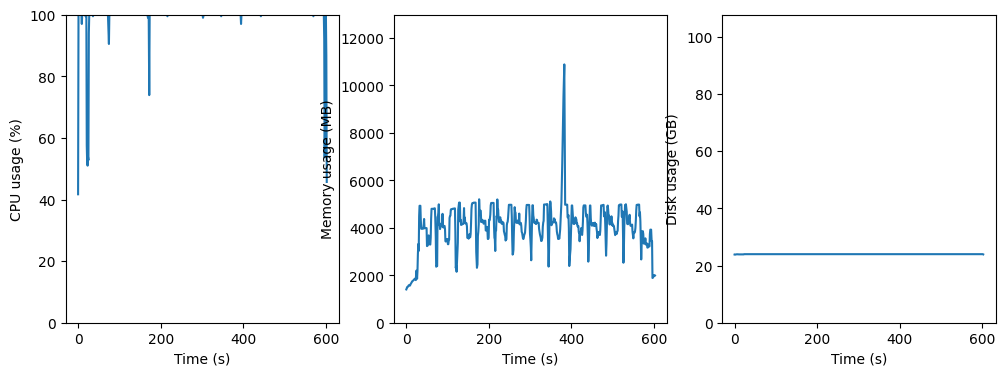

In [61]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time','radiomics_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in ['1.2.840.113654.2.55.22770087029972268579113866309746562015']:
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimageAndRadiomics, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [62]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4')
  os.remove(f'{curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4
!tar cvf - {curr_dir}/radiomics | lz4 > {curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4

output_archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/itkimage2segimage/
/content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015/
/content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.dcm.lz4
tar: Removing leading `/' from member names
/content/radiomics/
/content/radiomics/1.2.840.113654.2.55.22770087029972268579113866309746562015/
/content/radiomics/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_radiomics.json.lz4


###Utilization Metrics

In [63]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_archiving_time']=output_archiving_time
try:
  os.remove('itkimage2segimageUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv itkimage2segimageUsageMetrics.lz4
runtime_stats

Compressed 24258 bytes into 4859 bytes ==> 20.03%


,SeriesInstanceUID,itkimage2segimage_time,radiomics_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,output_archiving_time
0,1.2.840.113654.2.55.22770087029972268579113866...,14.1071,573.295962,0.219039,"[[[41.7, 100.0, 100.0, 100.0, 100.0, 100.0, 10...","[[[1403.7734375, 1446.1875, 1500.59375, 1500.5...",[12982.671875],"[[[23.843738555908203, 23.79882049560547, 23.8...",107.715084,0.212409


In [64]:
# !lz4 -d /content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.dcm.lz4

In [65]:
# from pydicom.filereader import dcmread
# seg_dcm = dcmread('/content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.dcm')
# SOPInstanceUID_seg = seg_dcm.file_meta['0x0002', '0x0003'].value
# SOPInstanceUID_seg                                                      

In [66]:
# !lz4 -d /content/radiomics/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_radiomics.json.lz4

In [67]:
# radiomics_features = pd.read_json('/content/radiomics/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_radiomics.json', orient='index')
# radiomics_features = radiomics_features.rename(columns=lambda x: x.split('_')[-1])
# radiomics_features = radiomics_features.reset_index().rename(columns={'index': 'body_part'})
# label_id_body_part_data = map_to_binary.class_map['total'].items()
# label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
# radiomics_features = pd.merge(radiomics_features, label_id_body_part_df, on='body_part')
# cols = radiomics_features.columns.tolist()
# cols.insert(1, cols.pop(cols.index('label_id')))
# radiomics_features = radiomics_features[cols]
# radiomics_features

In [68]:
# num_values = len(radiomics_features.columns)-2 
# feature_list = radiomics_features.columns[2:] 
# feature_list[0]

In [69]:
# SeriesInstanceUID='1.2.840.113654.2.55.22770087029972268579113866309746562015'
# SOPInstanceUID_seg='1.2.276.0.7230010.3.1.4.481037312.1199.1684330692.292908'
# pred_dicomseg_path='/content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.dcm'
# dcm_directory='/content/idc_data'
# nnunet_segments_code_mapping_df=pd.read_csv('/content/TotalSegmentator v1 SCT mapping - total.csv')
# nnunet_shape_features_code_mapping_df=pd.read_csv('/content/radiomicsFeaturesMaps.csv')
# df_features=radiomics_features


# measurement = [] 
# pyradiomics_version_number = str(radiomics.__version__)
# num_values = len(radiomics_features.columns)-2 
# feature_list = nnunet_shape_features_code_mapping_df.feature.to_list()



# for n in range(0,len(feature_list)): 
#   measurement_dict = {}
#   row = radiomics_features.loc[radiomics_features['body_part'] == 'clavicula_right']
#   feature_row = nnunet_shape_features_code_mapping_df.loc[nnunet_shape_features_code_mapping_df["feature"] == feature_list[n]]
#   value = str(np.round(row[feature_list[n]].values[0],3))
#   measurement_dict["value"] = value
#   measurement_dict["quantity"] = {}
#   measurement_dict["quantity"]["CodeValue"] = str(feature_row["quantity_CodeValue"].values[0])
#   measurement_dict["quantity"]["CodingSchemeDesignator"] = str(feature_row["quantity_CodingSchemeDesignator"].values[0])
#   measurement_dict["quantity"]["CodeMeaning"] = str(feature_row["quantity_CodeMeaning"].values[0])
#   measurement_dict["units"] = {}
#   measurement_dict["units"]["CodeValue"] = str(feature_row["units_CodeValue"].values[0])
#   measurement_dict["units"]["CodingSchemeDesignator"] = str(feature_row["units_CodingSchemeDesignator"].values[0])
#   measurement_dict["units"]["CodeMeaning"] = str(feature_row["units_CodeMeaning"].values[0])
#   measurement_dict["measurementAlgorithmIdentification"] = {}
#   measurement_dict["measurementAlgorithmIdentification"]["AlgorithmName"] = "pyradiomics"
#   measurement_dict["measurementAlgorithmIdentification"]["AlgorithmVersion"] = str(pyradiomics_version_number)
#   measurement.append(measurement_dict) 

# measurement

In [70]:
# radiomics_features

In [71]:
# nnunet_segments_code_mapping_df=pd.read_csv('/content/TotalSegmentator v1 SCT mapping - total.csv')
# nnunet_shape_features_code_mapping_df=pd.read_csv('/content/radiomicsFeaturesMaps.csv')
# df_features=radiomics_features
# segments_code_mapping_df=nnunet_segments_code_mapping_df


# for segment_id in range(1,10):

#     ReferencedSegment = radiomics_features['label_id'].values[segment_id]
#     FindingSite = radiomics_features['body_part'].values[segment_id]
#     print(FindingSite)
#     # print('segment_id: ' + str(segment_id))
#     # print('ReferencedSegment: ' + str(ReferencedSegment))
#     # print('FindingSite: ' + str(FindingSite))

#     # --- Create the dict for the Measurements group --- # 
#     TrackingIdentifier = "Measurements group " + str(ReferencedSegment)

#     segment_row = segments_code_mapping_df[segments_code_mapping_df["Structure"] == FindingSite]

#     # segments_code_mapping_df = segments_code_mapping_df.set_index("Structure")

#     # segment_row = segments_code_mapping_df.loc[FindingSite]

In [72]:
# SeriesInstanceUID='1.2.840.113654.2.55.22770087029972268579113866309746562015'
# SOPInstanceUID_seg='1.2.276.0.7230010.3.1.4.481037312.1199.1684330692.292908'
# pred_dicomseg_path='/content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.dcm'
# dcm_directory='/content/idc_data'
# nnunet_segments_code_mapping_df=pd.read_csv('/content/TotalSegmentator v1 SCT mapping - total.csv')
# nnunet_shape_features_code_mapping_df=pd.read_csv('/content/radiomicsFeaturesMaps.csv')
# df_features=radiomics_features

# inputMetadata = create_structured_report_metajson_for_shape_features(SeriesInstanceUID, 
#                                                                        SOPInstanceUID_seg,
#                                                                        pred_dicomseg_path, 
#                                                                        dcm_directory, 
#                                                                        nnunet_segments_code_mapping_df, 
#                                                                        nnunet_shape_features_code_mapping_df,
#                                                                        df_features)

# print ('created SR json for shape features')

# # --- Write out json --- #

# with open('a.json', 'w') as f:
#   json.dump(inputMetadata, f, indent=2)
# print ('wrote out json for shape features')

In [73]:
# inputImageLibraryDirectory= '/content/idc_data'
# outputDICOM='output.dcm'
# inputCompositeContextDirectory='/content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015'
# inputMetadata_json='/content/a3.json'

# !tid1500writer --inputImageLibraryDirectory $inputImageLibraryDirectory \
#               --outputDICOM $outputDICOM  \
#               --inputCompositeContextDirectory $inputCompositeContextDirectory \
#               --inputMetadata $inputMetadata_json

